# Inference

## 0. imports

In [1]:
%load_ext jupyter_black

In [2]:
import sys

sys.path.append("..")

In [3]:
import os
import glob

import cv2
import omegaconf

import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm.auto import tqdm, trange

import matplotlib.pyplot as plt

In [4]:
from src.model.clip import CLIP
from src.dataset.datamodule import CLIPDataModule
from src.module.trainer import Trainer
from src.module.utils import AverageMeter, fix_seed

In [5]:
import warnings

warnings.filterwarnings("ignore")

## 1. Train

In [6]:
# transformers - tokenizers warning off
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [7]:
config_path = "./clip_config.yaml"
config = omegaconf.OmegaConf.load(config_path)
scaler = torch.cuda.amp.GradScaler()

fix_seed(seed=config.train.seed)

trainer = Trainer(config=config, scaler=scaler)

In [10]:
version = trainer.fit()

## 2. Inference

### 2.1 load trained model

In [8]:
def load_trained_model(config, device: str):
    version = config.version
    dataset_name = config.datamodule.dataset_name

    ckpt_list = glob.glob(
        os.path.join(config.train.ckpt_dir, f"{dataset_name}-version-{version}/*.pt")
    )

    state_dict = torch.load(ckpt_list[-1])
    model = CLIP(**config.model)
    model.load_state_dict(state_dict)
    model = model.to(device)

    return model

In [9]:
config.version = version
device = "cuda" if torch.cuda.is_available() else "cpu"

model = load_trained_model(config, device)

### 2.2 get image embeddings

In [10]:
def get_img_embeddings(model, img: torch.Tensor):
    model.eval()
    with torch.no_grad():
        img_features = model.img_encoder(img)
        img_embeddings = model.img_projection(img_features)

    return img_embeddings

In [11]:
test_dataloader = trainer.dm.test_dataloader()

img_embeddings = []
for batch in tqdm(test_dataloader, total=len(test_dataloader)):
    batch = {k: v.to(device) for k, v in batch.items() if k != "caption"}

    img_embedding = get_img_embeddings(model, batch["image"])
    img_embeddings.append(img_embedding)

img_embeddings = torch.cat(img_embeddings)

  0%|          | 0/253 [00:00<?, ?it/s]

In [12]:
img_embeddings.shape

torch.Size([8091, 256])

### 2.3 find matches

In [13]:
def find_matches(
    model,
    tokenizer,
    query: str,
    img_embeddings: torch.Tensor,
    img_paths: list[str],
    topk: int = 9,
) -> None:
    encoded_query = tokenizer([query], return_tensors="pt")
    batch = {k: v.to(device) for k, v in encoded_query.items()}

    model.eval()
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    img_embeddings_norm = F.normalize(img_embeddings, p=2, dim=-1)
    text_embeddings_norm = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_norm @ img_embeddings_norm.T

    _, idxs = torch.topk(dot_similarity.squeeze(0), topk * 5)
    matches = [img_paths[idx] for idx in idxs[::5]]

    fig, axes = plt.subplots(3, 3, figsize=(10, 10))
    for match, ax in zip(matches, axes.flatten()):
        image = cv2.imread(f"{config.datamodule.img_dir}/{match}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        ax.imshow(image)
        ax.axis("off")

    plt.suptitle(f"Qeury: {query}")
    fig.tight_layout()
    plt.show()

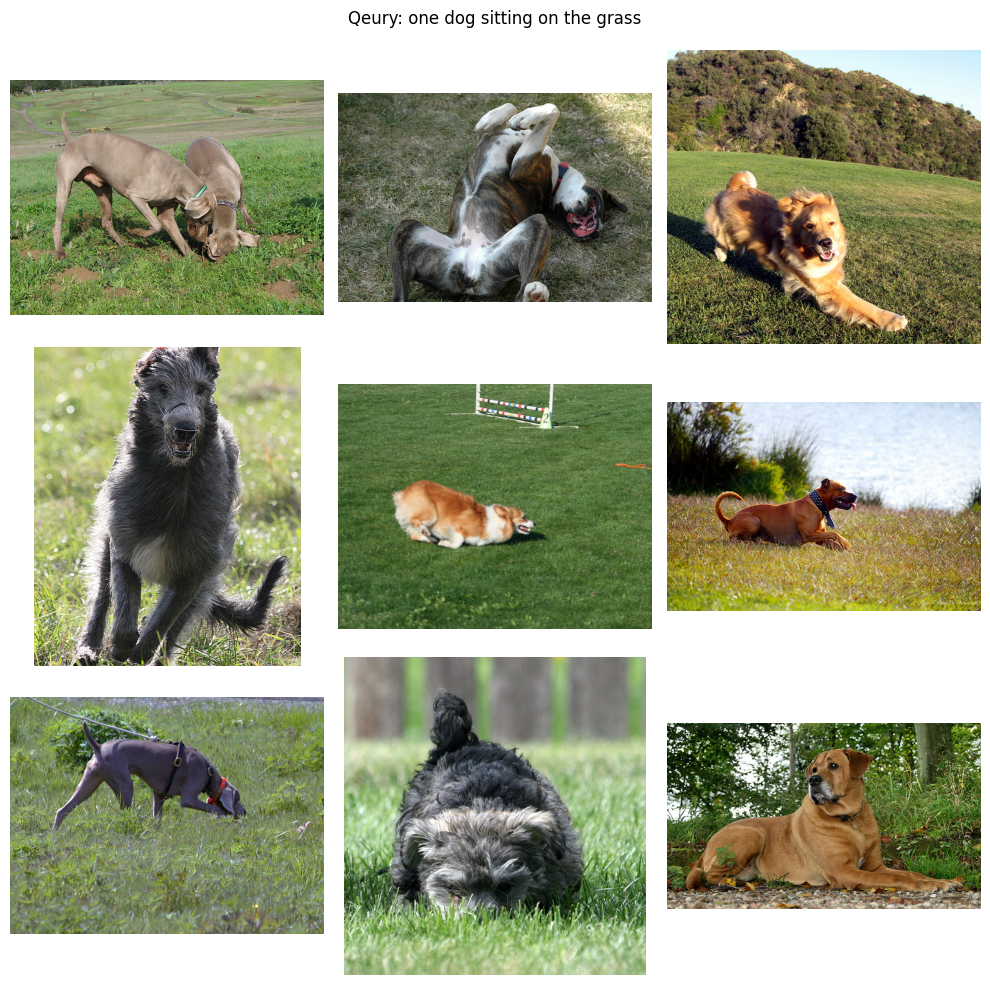

In [15]:
topk = 9
query = "one dog sitting on the grass"

tokenizer = trainer.dm.tokenizer
img_paths = trainer.dm.test_df["image"].tolist()

find_matches(model, tokenizer, query, img_embeddings, img_paths, topk)